In [70]:
import os
from glob import glob
from shutil import copyfile, move
from collections import defaultdict

import tensorflow as tf 
import tensorflow_io as tfio

from tensorflow.keras import layers
from tensorflow.keras import models

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [27]:
# move data to "original" folder
print(os.listdir("./data/"))
if not os.path.exists("./data/original") and not os.path.exists("./data/filtered"):
    #
    for folder in os.listdir("./data/")[1:]:
        move(f"./data/{folder}", f"./data/original/{folder}")

print(os.listdir("./data/"))

['.DS_Store', 'original']
['.DS_Store', 'original']


In [28]:
audio_files = glob("./data/original/*/*.wav")

# Dataset statistics

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 22050 Hz to 16000 Hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [3]:
def get_lang_dict(dirpath):
    lang_dict = defaultdict(list)
    audio_files = glob(dirpath)

    for file in audio_files:
        lang = file.split("/")[3]
        tensor_wave = load_wav_16k_mono(file)
        lang_dict[lang].append(len(tensor_wave))
    return lang_dict

In [4]:
def get_stats(dirpath):
    '''
    returns statistics for two dataframes:
    df_stats_frames = duration measured in number of frames
    df_stats_duration = duration measured in seconds 
    '''
    lang_dict = get_lang_dict(dirpath)
    df_stats_frames = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], columns=[lang for lang in lang_dict])
    df_stats_duration = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], columns=[lang for lang in lang_dict])
    for lang in lang_dict:
        df_audio = pd.DataFrame({lang: lang_dict[lang]})
        duration_len = [l/16000 for l in lang_dict[lang]]
        df_audio_duration = pd.DataFrame({lang: duration_len}) 
        df_stats_frames[lang] = df_audio.describe()
        df_stats_duration[lang] = df_audio_duration.describe()
    return df_stats_frames, df_stats_duration

In [5]:
ORIGINAL_DATASET_PATH = "./data/original/*/*.wav"
df_stats_frames, df_stats_duration = get_stats(ORIGINAL_DATASET_PATH)

2022-11-30 21:57:20.748001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 21:57:20.950387: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [6]:
df_stats_duration

,german,mandarin,russian,english
count,45.000000,156.000000,81.000000,70.000000
mean,24.603707,30.816357,29.573221,23.884626
std,3.010575,6.798004,8.871547,3.786617
min,19.229125,18.924250,18.896687,16.460500
25%,22.824687,25.486313,23.447125,21.291281
50%,24.412375,29.745625,27.433250,23.733875
75%,26.038625,34.685141,33.418312,25.624266
max,34.014812,55.590000,66.142000,35.974000


Number of files per language is very varying - ranging from 45 audio clips for German to 156 for Mandarin. 
The clips duration is also very different - from about 16 sec for English, up to 66 sec for Russian.

Preprocessing decisions:
1. limit number of audio files per language to 45 to avoid imbalanced dataset
2. ensure the file duration is 19 seconds (skip those that are less than 19, trim if longer)

In [7]:
df_stats_frames

,german,mandarin,russian,english
count,45.000000,156.000000,8.100000e+01,70.000000
mean,393659.311111,493061.711538,4.731715e+05,382154.014286
std,48169.197338,108768.058246,1.419447e+05,60585.867666
min,307666.000000,302788.000000,3.023470e+05,263368.000000
25%,365195.000000,407781.000000,3.751540e+05,340660.500000
50%,390598.000000,475930.000000,4.389320e+05,379742.000000
75%,416618.000000,554962.250000,5.346930e+05,409988.250000
max,544237.000000,889440.000000,1.058272e+06,575584.000000


# Filter by country

In [10]:
countries = ["russia", "germany", "usa", "china"]

for file in audio_files:
    lang = file.split("/")[3]
    filename = file.split("/")[-1]
    country = filename.split("_")[-1].split(".wav")[0]
    if country in countries:
        dst = f"./data/filtered/{lang}"
        if not os.path.exists(dst):
            os.makedirs(dst)
        copyfile(file, f"{dst}/{filename}")

In [11]:
FILTERED_DATASET_PATH = "./data/filtered/*/*.wav"
df_stats_frames, df_stats_duration = get_stats(FILTERED_DATASET_PATH)

In [12]:
df_stats_duration

,german,mandarin,russian,english
count,35.000000,138.000000,56.000000,42.000000
mean,24.662941,30.884267,30.019041,23.468746
std,3.140721,6.724104,8.992358,3.547399
min,19.997688,18.924250,18.896687,16.460500
25%,22.681250,25.622953,24.153312,21.356094
50%,24.412375,30.094875,27.674500,23.194313
75%,26.252812,34.665766,33.471906,25.712531
max,34.014812,55.590000,66.142000,31.362063


In [41]:
min_num = int(df_stats_duration.T['count'].min())
min_num

35

In [46]:
languages = os.listdir("./data/original")
languages

['german', 'mandarin', 'russian', 'english']

In [44]:
#!! DELETES files from "filtered" folder to make balanced dataset
for lang in languages:
    files_per_lang = glob(f"./data/filtered/{lang}/*.wav")
    for i, file in enumerate(files_per_lang):
        if i >= min_num:
            os.remove(file)

# STFT

Code below adopted from ["Simple audio recognition: Recognizing keywords"](https://www.tensorflow.org/tutorials/audio/simple_audio)


In [ ]:
min_duration = int(df_stats_duration.T['min'].min())
min_duration

In [48]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="./data/filtered/",
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000 * min_duration,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 140 files belonging to 4 classes.
Using 112 files for training.
Using 28 files for validation.

label names: ['english' 'german' 'mandarin' 'russian']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [50]:
train_ds.element_spec

(TensorSpec(shape=(None, 256000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:

In [51]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The utils.audio_dataset_from_directory function only returns up to two splits. It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, but in this case you can use Dataset.shard to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep it's fraction.

In [52]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [53]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 256000)
(64,)


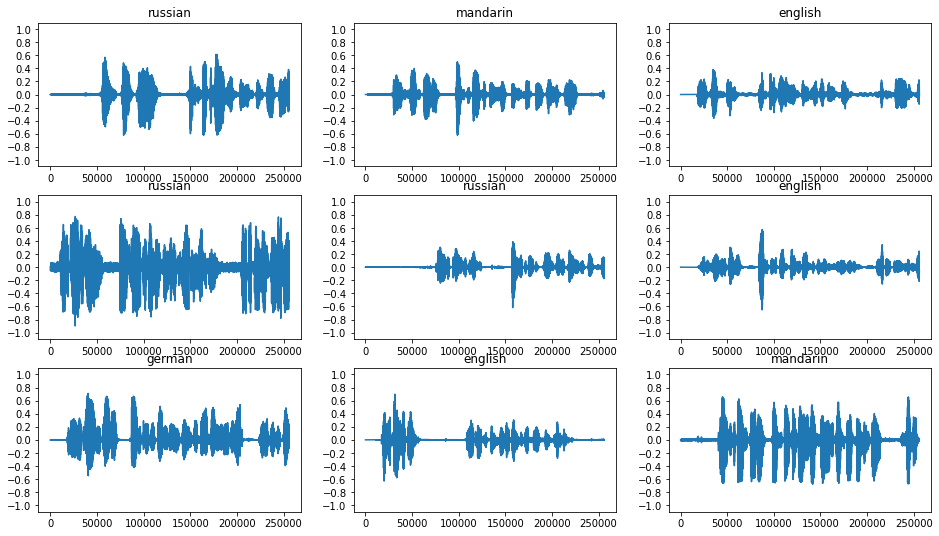

In [57]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i>=n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

plt.show()

In [63]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [58]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [59]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [60]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [61]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

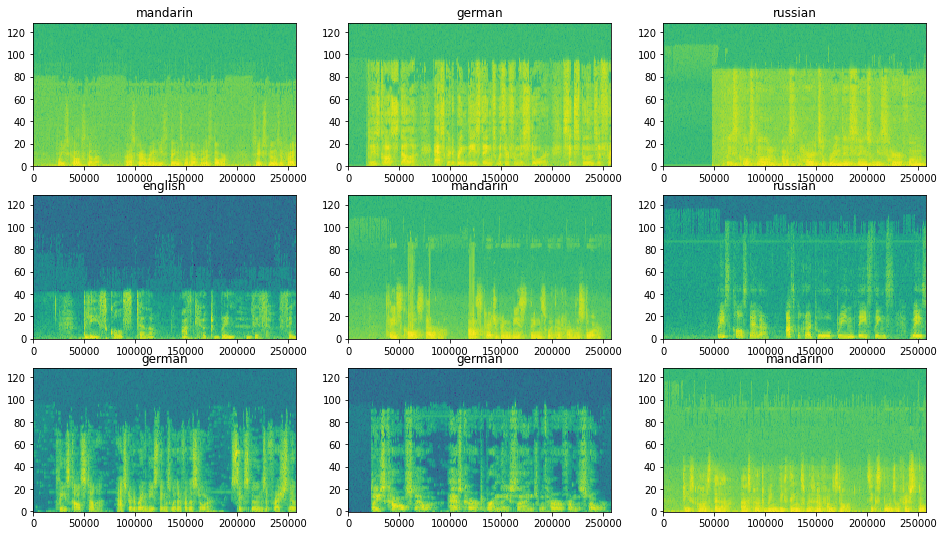

In [65]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(languages[example_spect_labels[i].numpy()])

plt.show()

# Modeling

In [66]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [71]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(languages)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (1999, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)          

In [72]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [77]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
2/2 [==============================] - 1s 370ms/step - loss: 0.4752 - accuracy: 0.8125
Epoch 2/10
2/2 [==============================] - 0s 201ms/step - loss: 0.4659 - accuracy: 0.8304
Epoch 3/10
2/2 [==============================] - 0s 192ms/step - loss: 0.3517 - accuracy: 0.9107
Epoch 4/10
2/2 [==============================] - 0s 204ms/step - loss: 0.4074 - accuracy: 0.8482
Epoch 5/10
2/2 [==============================] - 0s 194ms/step - loss: 0.2246 - accuracy: 0.9464
Epoch 6/10
2/2 [==============================] - 0s 184ms/step - loss: 0.2737 - accuracy: 0.9286
Epoch 7/10
2/2 [==============================] - 0s 189ms/step - loss: 0.2264 - accuracy: 0.9375
Epoch 8/10
2/2 [==============================] - 0s 186ms/step - loss: 0.1545 - accuracy: 0.9732
Epoch 9/10
2/2 [==============================] - 0s 178ms/step - loss: 0.1882 - accuracy: 0.9464
Epoch 10/10
2/2 [==============================] - 0s 183ms/step - loss: 0.1602 - accuracy: 0.9375


In [79]:
metrics

{'loss': [0.4751739501953125,
  0.4659094512462616,
  0.3516588509082794,
  0.4073643684387207,
  0.22457239031791687,
  0.2736629843711853,
  0.22639942169189453,
  0.15447579324245453,
  0.18824656307697296,
  0.16015338897705078],
 'accuracy': [0.8125,
  0.8303571343421936,
  0.9107142686843872,
  0.8482142686843872,
  0.9464285969734192,
  0.9285714030265808,
  0.9375,
  0.9732142686843872,
  0.9464285969734192,
  0.9375]}

In [74]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 2s 2s/step - loss: 1.6494 - accuracy: 0.3214


{'loss': 1.6493700742721558, 'accuracy': 0.3214285671710968}